In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
source_path = '/content/drive/MyDrive/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Delete all non-image files 
!find /kaggle/working/microsoft-catsvsdogs-dataset/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# Lets see how many files we have under each path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")
# There are 12500 images of dogs.
# There are 12500 images of cats.

find: ‘/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/’: No such file or directory
There are 12501 images of dogs.
There are 5053 images of cats.


In [15]:
###This section creates respective folders which is going to be used later by ImageDataGenerator###

#This will be our root directory for training and validation data
root_dir = '/kaggle/working/microsoft-catsvsdogs-dataset/cats-v-dogs'
# Empty directory to prevent FileExistsError if this piece of code is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

#Make a training folder inside our root_dir
train_dir = os.path.join(root_dir, 'training')
os.makedirs(train_dir)
#Make a validation folder inside our root_dir
validation_dir = os.path.join(root_dir, 'validation')
os.makedirs(validation_dir)

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir)

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir)

In [16]:
###In this section we are going to split our data into test and validation sets.
#We define a function which will later be called for cats and dogs seperately
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR):
    #Get a list of all the file names
    images = list(file for file in os.listdir(SOURCE_DIR) if os.path.isfile(os.path.join(SOURCE_DIR, file)))
    for file in images:
        #Check to see if the file size is zero, then ignore those
        if os.path.getsize(os.path.join(SOURCE_DIR, file)) == 0:
            print(file,' is zero length, so ignoring.')
            images.remove(file)
    #Now that we have our image filenames, we randomly shuffle them to be used for validation and training
    images = random.sample(images, len(images))
    #In this section, I decided to split data with the following ratio: 10% validation data, 90% training data. I first populate validation data 
    for i in range(len(images)):
        if i < len(images) *(0.1) :
            copyfile(os.path.join(SOURCE_DIR, images[i]), os.path.join(VALIDATION_DIR, images[i]))
        else:
            copyfile(os.path.join(SOURCE_DIR, images[i]), os.path.join(TRAINING_DIR, images[i]))

In [17]:
# Define paths
CAT_SOURCE_DIR = "/content/drive/MyDrive/PetImages/Cat"
DOG_SOURCE_DIR = "/content/drive/MyDrive/PetImages/Cat"

TRAINING_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/cats-v-dogs/training"
VALIDATION_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/cats-v-dogs/validation"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
    for file in os.scandir(VALIDATION_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
    for file in os.scandir(VALIDATION_DOGS_DIR):
        os.remove(file.path)


# Run the function
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR)

print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")



Original cat's directory has 5231 images
Original dog's directory has 5231 images

There are 4575 images of cats for training
There are 4680 images of dogs for training
There are 509 images of cats for validation
There are 521 images of dogs for validation


In [18]:
# After successfully organizing and splitting the data into training and validation sets in their respective folders, it is time for to code the  ImageDataGenerator that will yield batches of images. 

#Images in this dataset are of different sizes, that is why we use  parameter target_size for 'flow_from_directory' method to standarize 

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class 
    train_datagen = ImageDataGenerator( rescale = 1.0/255. ) 
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=40,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class 
    validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=40,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  
    return train_generator, validation_generator

In [19]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 9253 images belonging to 2 classes.
Found 1030 images belonging to 2 classes.


In [20]:
from tensorflow.keras.optimizers import RMSprop

def create_model():
    model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid') 
  ])

    model.summary()
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    return model

In [21]:
# Get the untrained model
model = create_model()

# Time to train our model
#This will take some time (around 45 minutes)
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [22]:
model.save("model1_catsVSdogs_10epoch.h5")

In [23]:
import pickle
# create a binary pickle file for the history to be saved
f = open("/kaggle/working/history.pkl","wb")

# write the python object  to pickle file
pickle.dump(history.history,f)

# close file
f.close()

In [24]:
history = pd.read_pickle('/kaggle/working/history.pkl')

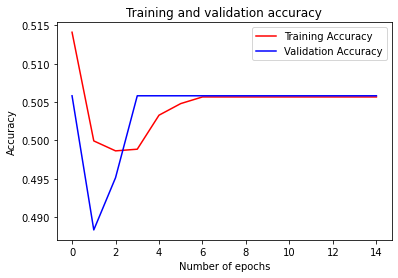

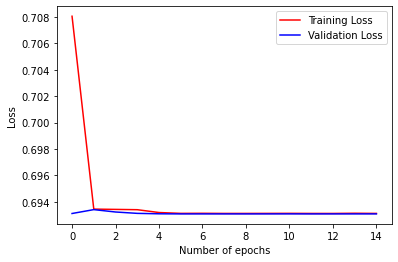

In [25]:
acc=history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r',label =  "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()
print("")

# Plot training and validation loss per epoch
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend()
plt.show()